# Plot Label Resampling Performance

In [1]:
from pathlib import Path

import scipy.stats
import pandas as pd
import plotnine as p9
import plydata as ply

## Gather performance dataset files and manipulate the dataframes

In [2]:
performance_dfs = pd.concat(
    [
        pd.read_csv(str(df_path), sep="\t")
        >> ply.define(lf_num=ply.expressions.if_else("lf_num > 97", 99, "lf_num"))
        >> ply.define(
            lf_num=ply.expressions.case_when(
                {
                    "lf_num==1": "lf_num",
                    "lf_num==33": "lf_num",
                    "lf_num==65": "lf_num",
                    "lf_num==97": "lf_num",
                    "lf_num==99": "lf_num",
                    True: 0,
                }
            )
        )
        >> ply.define(
            prediction_label='"' + df_path.stem.split("_")[1] + '"',
        )
        for df_path in Path("output").rglob("*tsv")
    ]
)
print(performance_dfs.shape)
performance_dfs.head()

(2040, 21)


,lf_num,auroc,aupr,bce_loss,sampled_lf_name,label_source,data_source,model,epochs,l2_param,...,prediction_label,aupr_mean,aupr_upper_ci,aupr_lower_ci,auroc_mean,auroc_upper_ci,auroc_lower_ci,bce_mean,bce_upper_ci,bce_lower_ci
0,1,0.703371,0.246039,1.167654,"LF_HETNET_HI_I_05,LF_HETNET_VENKATESAN_09,LF_H...",ALL,abstract,tune,500.0,1.2575,...,GiG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.695537,0.314388,1.014464,"LF_HETNET_HI_I_05,LF_HETNET_VENKATESAN_09,LF_H...",ALL,abstract,test,500.0,1.2575,...,GiG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,0.673087,0.230597,1.120538,"LF_HETNET_HI_I_05,LF_HETNET_VENKATESAN_09,LF_H...",ALL,abstract,tune,500.0,1.2575,...,GiG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0.662550,0.290350,0.933918,"LF_HETNET_HI_I_05,LF_HETNET_VENKATESAN_09,LF_H...",ALL,abstract,test,500.0,1.2575,...,GiG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,0.699564,0.201521,1.239366,"LF_HETNET_HI_I_05,LF_HETNET_VENKATESAN_09,LF_H...",ALL,abstract,tune,500.0,2.5050,...,GiG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
entity_labels = (
    performance_dfs
    >> ply.select("label_source")
    >> ply.distinct()
    >> ply.pull("label_source")
)

data_rows = []
for idx, row in performance_dfs >> ply.query("lf_num==0") >> ply.call(".iterrows"):

    for entity in entity_labels:

        if entity == row["label_source"]:
            continue

        data_rows.append(
            {
                "lf_num": 0,
                "aupr": row["aupr"],
                "auroc": row["auroc"],
                "bce_loss": row["bce_loss"],
                "sampeld_lf_name": row["sampled_lf_name"],
                "label_source": entity,
                "data_source": row["data_source"],
                "prediction_label": row["prediction_label"],
            }
        )

In [4]:
def upper_ci(x):
    return x.mean() + (
        scipy.stats.sem(x) * scipy.stats.t.ppf((1 + 0.95) / 2.0, len(x) - 1)
    )


def lower_ci(x):
    return x.mean() - (
        scipy.stats.sem(x) * scipy.stats.t.ppf((1 + 0.95) / 2.0, len(x) - 1)
    )

In [5]:
performance_ci_df = (
    performance_dfs
    >> ply.call(".append", pd.DataFrame.from_records(data_rows))
    >> ply.group_by(
        "lf_num", "label_source", "prediction_label", "data_source", "model"
    )
    >> ply.define(
        aupr_mean="mean(aupr)",
        aupr_upper_ci="upper_ci(aupr)",
        aupr_lower_ci="lower_ci(aupr)",
    )
    >> ply.define(
        auroc_mean="mean(auroc)",
        auroc_upper_ci="upper_ci(auroc)",
        auroc_lower_ci="lower_ci(auroc)",
    )
    >> ply.define(
        bce_mean="mean(bce_loss)",
        bce_upper_ci="upper_ci(bce_loss)",
        bce_lower_ci="lower_ci(bce_loss)",
    )
    >> ply.ungroup()
    >> ply.define(lf_sample=ply.expressions.if_else("lf_num==99", '"All"', "lf_num"))
    >> ply.select(
        "lf_num",
        "label_source",
        "prediction_label",
        "data_source",
        "model",
        "aupr_mean",
        "aupr_upper_ci",
        "aupr_lower_ci",
        "auroc_mean",
        "auroc_upper_ci",
        "auroc_lower_ci",
        "bce_mean",
        "bce_upper_ci",
        "bce_lower_ci",
    )
    >> ply.call(".dropna")
    >> ply.distinct()
)
performance_ci_df.lf_num = pd.Categorical(performance_ci_df.lf_num.astype(int).tolist())
performance_ci_df >> ply.call(
    "to_csv", "output/generative_model_all_lf_performance.tsv", sep="\t", index=False
)
performance_ci_df

,lf_num,label_source,prediction_label,data_source,model,aupr_mean,aupr_upper_ci,aupr_lower_ci,auroc_mean,auroc_upper_ci,auroc_lower_ci,bce_mean,bce_upper_ci,bce_lower_ci
0,1,ALL,GiG,abstract,tune,0.203718,0.209861,0.197575,0.673699,0.677176,0.670221,2.024274,2.717180,1.331369
1,1,ALL,GiG,abstract,test,0.299752,0.303289,0.296215,0.661429,0.664744,0.658114,1.518805,1.960492,1.077118
100,33,ALL,GiG,abstract,tune,0.238406,0.252841,0.223971,0.705633,0.720845,0.690422,2.161190,3.165923,1.156458
101,33,ALL,GiG,abstract,test,0.254714,0.265318,0.244110,0.668499,0.681552,0.655445,2.421302,3.332552,1.510052
200,65,ALL,GiG,abstract,tune,0.207883,0.217622,0.198144,0.696941,0.708812,0.685070,1.673600,1.878800,1.468400
201,65,ALL,GiG,abstract,test,0.226827,0.234388,0.219267,0.644986,0.655087,0.634885,2.350597,2.642073,2.059122
300,97,ALL,GiG,abstract,tune,0.189919,0.191195,0.188643,0.686947,0.688782,0.685111,2.343603,2.390361,2.296844
301,97,ALL,GiG,abstract,test,0.209034,0.210168,0.207899,0.630345,0.632055,0.628636,3.489914,3.567844,3.411984
400,99,ALL,GiG,abstract,tune,0.188283,0.188283,0.188283,0.684830,0.684830,0.684830,2.412497,2.412497,2.412497
401,99,ALL,GiG,abstract,test,0.207790,0.207790,0.207790,0.629143,0.629143,0.629143,3.524590,3.524590,3.524590


# Plot Different Dataset Performance

## Tune

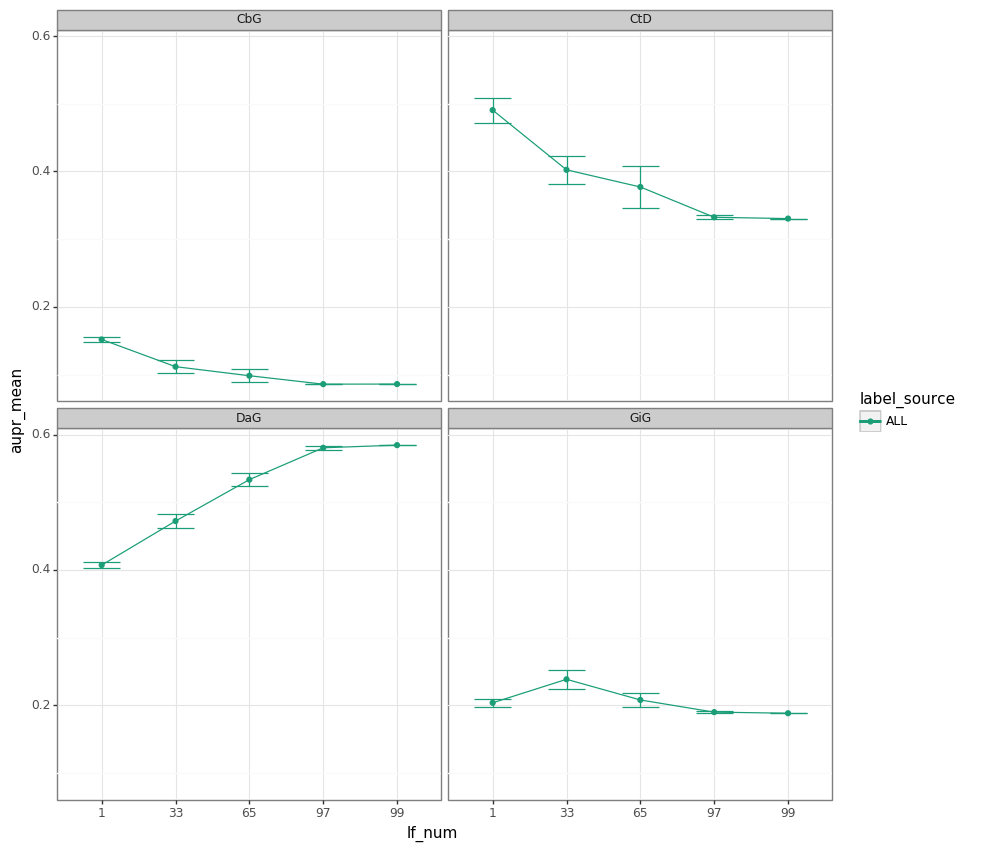

<ggplot: (-9223363295792552444)>


In [6]:
g = (
    p9.ggplot(performance_ci_df >> ply.query("model=='tune'"))
    + p9.aes(
        x="lf_num",
        y="aupr_mean",
        ymin="aupr_lower_ci",
        ymax="aupr_upper_ci",
        group="label_source",
        color="label_source",
    )
    + p9.geom_point()
    + p9.geom_line()
    + p9.geom_errorbar()
    + p9.facet_wrap("~ prediction_label")
    + p9.theme_bw()
    + p9.theme(figure_size=(10, 10))
    + p9.scale_color_brewer(type="qual", palette=2)
)
print(g)

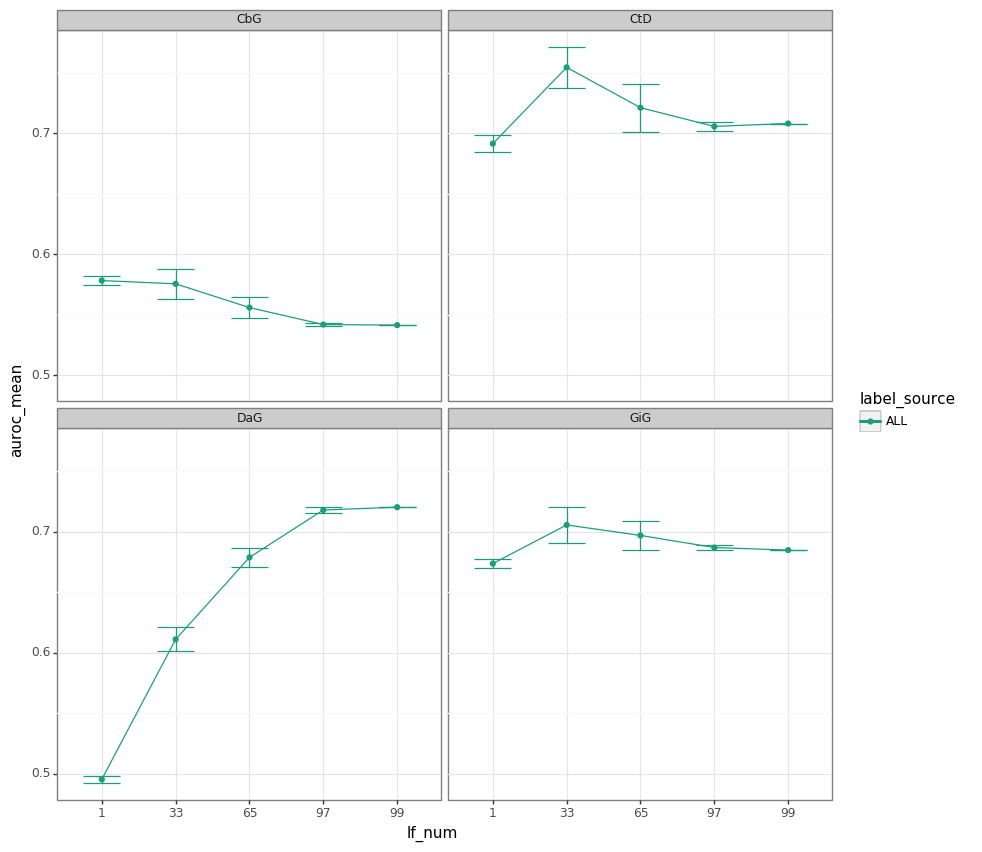

<ggplot: (-9223363295795454562)>


In [7]:
g = (
    p9.ggplot(performance_ci_df >> ply.query("model=='tune'"))
    + p9.aes(
        x="lf_num",
        y="auroc_mean",
        ymin="auroc_lower_ci",
        ymax="auroc_upper_ci",
        group="label_source",
        color="label_source",
    )
    + p9.geom_point()
    + p9.geom_line()
    + p9.geom_errorbar()
    + p9.facet_wrap("~ prediction_label")
    + p9.theme_bw()
    + p9.theme(figure_size=(10, 10))
    + p9.scale_color_brewer(type="qual", palette=2)
)
print(g)

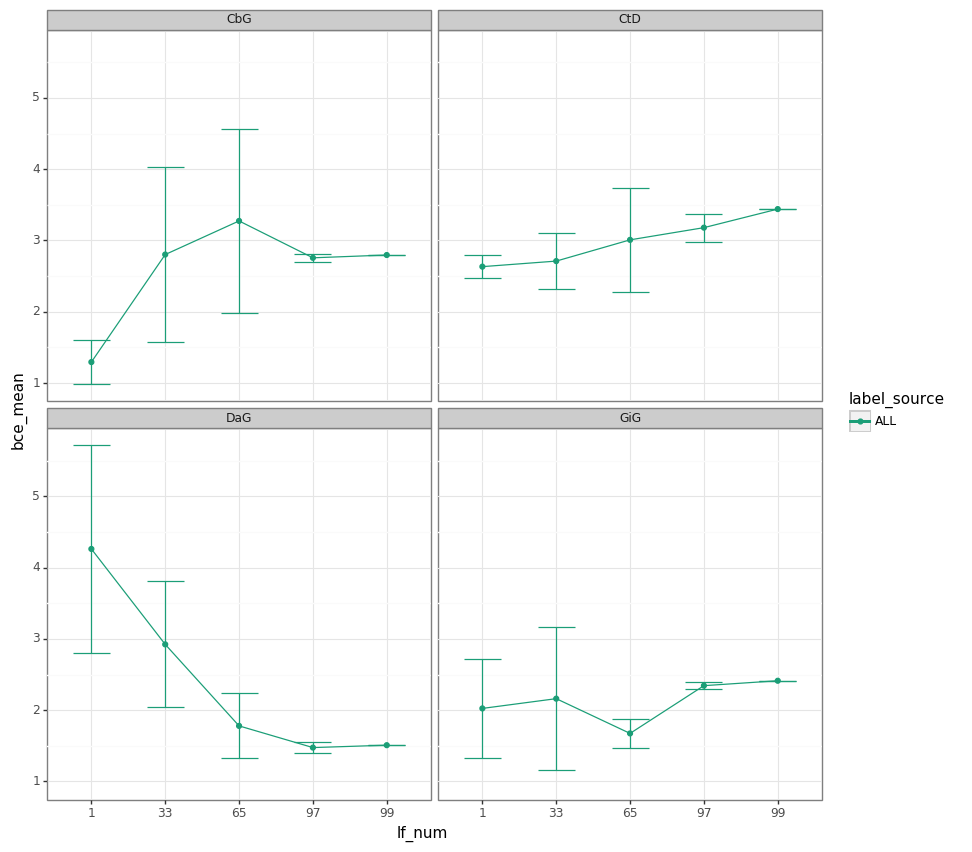

<ggplot: (8741059320412)>


In [8]:
g = (
    p9.ggplot(performance_ci_df >> ply.query("model=='tune'"))
    + p9.aes(
        x="lf_num",
        y="bce_mean",
        ymin="bce_lower_ci",
        ymax="bce_upper_ci",
        group="label_source",
        color="label_source",
    )
    + p9.geom_point()
    + p9.geom_line()
    + p9.geom_errorbar()
    + p9.facet_wrap("~ prediction_label")
    + p9.theme_bw()
    + p9.theme(figure_size=(10, 10))
    + p9.scale_color_brewer(type="qual", palette=2)
)
print(g)

## Test

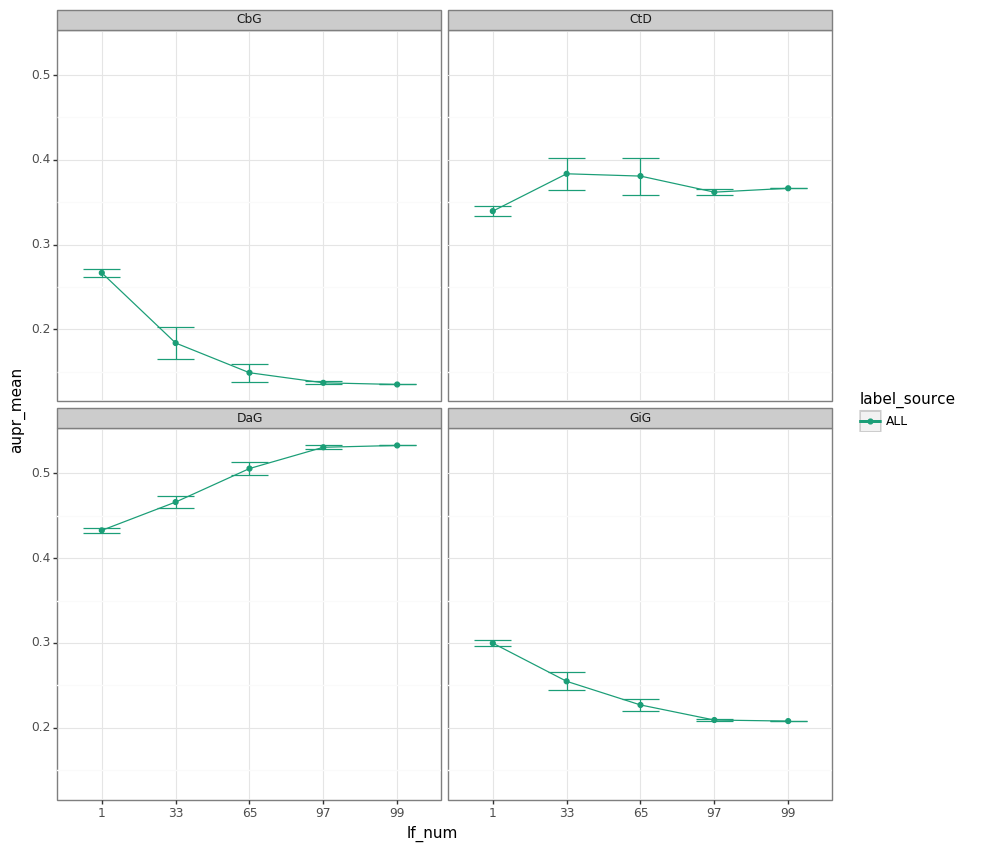

<ggplot: (8741059350669)>


In [9]:
g = (
    p9.ggplot(performance_ci_df >> ply.query("model=='test'"))
    + p9.aes(
        x="lf_num",
        y="aupr_mean",
        ymin="aupr_lower_ci",
        ymax="aupr_upper_ci",
        group="label_source",
        color="label_source",
    )
    + p9.geom_point()
    + p9.geom_line()
    + p9.geom_errorbar()
    + p9.facet_wrap("~ prediction_label")
    + p9.theme_bw()
    + p9.theme(figure_size=(10, 10))
    + p9.scale_color_brewer(type="qual", palette=2)
)
print(g)

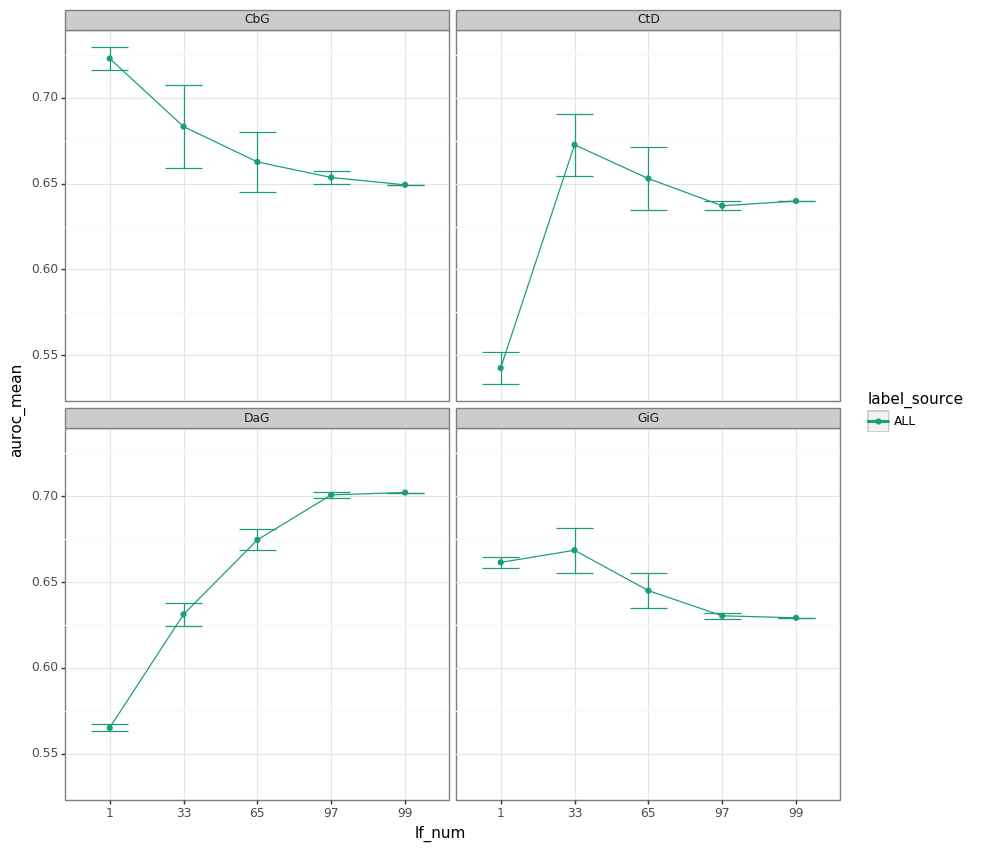

<ggplot: (8741059011157)>


In [10]:
g = (
    p9.ggplot(performance_ci_df >> ply.query("model=='test'"))
    + p9.aes(
        x="lf_num",
        y="auroc_mean",
        ymin="auroc_lower_ci",
        ymax="auroc_upper_ci",
        group="label_source",
        color="label_source",
    )
    + p9.geom_point()
    + p9.geom_line()
    + p9.geom_errorbar()
    + p9.facet_wrap("~ prediction_label")
    + p9.theme_bw()
    + p9.theme(figure_size=(10, 10))
    + p9.scale_color_brewer(type="qual", palette=2)
)
print(g)

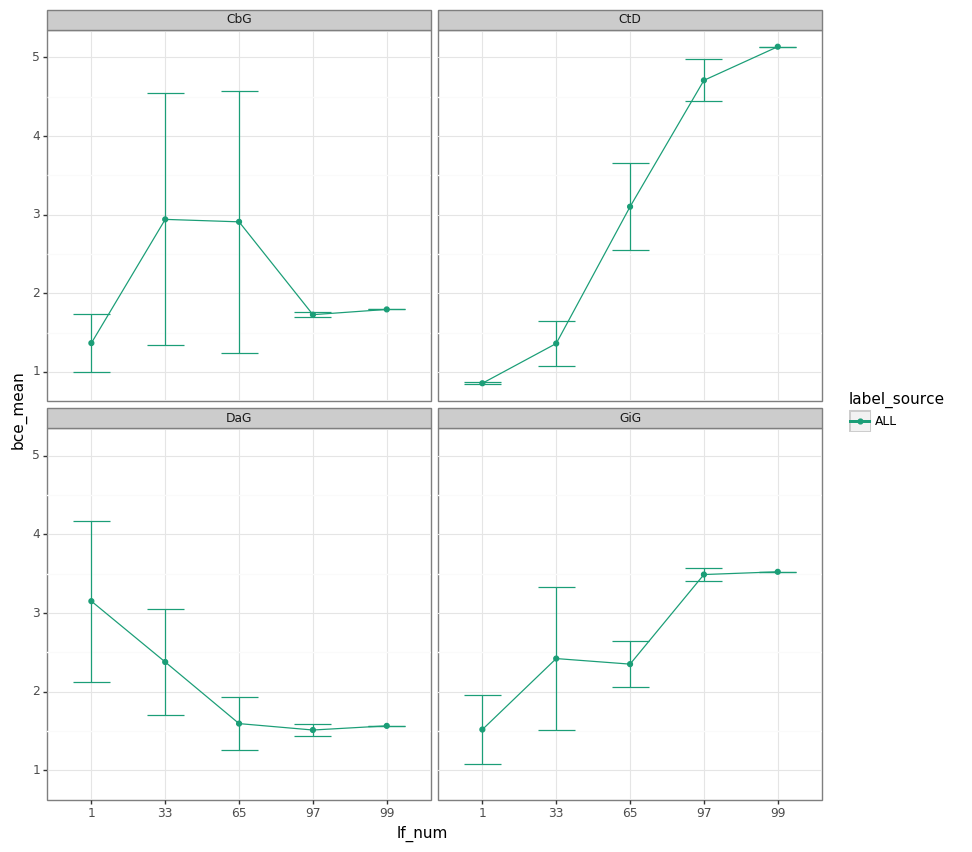

<ggplot: (8741058901775)>


In [11]:
g = (
    p9.ggplot(performance_ci_df >> ply.query("model=='test'"))
    + p9.aes(
        x="lf_num",
        y="bce_mean",
        ymin="bce_lower_ci",
        ymax="bce_upper_ci",
        group="label_source",
        color="label_source",
    )
    + p9.geom_point()
    + p9.geom_line()
    + p9.geom_errorbar()
    + p9.facet_wrap("~ prediction_label")
    + p9.theme_bw()
    + p9.theme(figure_size=(10, 10))
    + p9.scale_color_brewer(type="qual", palette=2)
)
print(g)